## Classifying News Headlines With Transformers & scikit-learn

The UCI ML News Aggregator Dataset contains headlines and categories for over 400k news articles. Let's see if we can accurately classify the news category based just on the headline

We would use spaCy wrapper for sentence transformers, spacy-sentence-bert from

https://github.com/MartinoMensio/spacy-sentence-bert

to compute dense vector representations for sentences, paragraphs, and images. The model is based on transformer networks like BERT / RoBERTa / XLM-RoBERTa etc. and achieve state-of-the-art performance in various task. Text is embedding in vector space such that similar text is close and can efficiently be found using cosine similarity.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
news = pd.read_csv("uci-news-aggregator.csv")

In [3]:
news = news[["TITLE", "CATEGORY"]]

In [4]:
dict = {'TITLE': 'title',
        'CATEGORY': 'topic'}
 
news.rename(columns=dict,
          inplace=True)

In [5]:
news.shape

(422419, 2)

In [7]:
news.head()

,title,topic
0,"Fed official says weak data caused by weather,...",b
1,Fed's Charles Plosser sees high bar for change...,b
2,US open: Stocks fall after Fed official hints ...,b
3,"Fed risks falling 'behind the curve', Charles ...",b
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,b


In [6]:
print(news.topic.unique())

['b' 't' 'e' 'm']


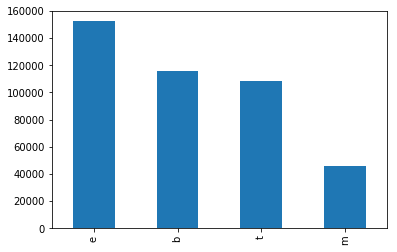

In [8]:
news['topic'].value_counts().plot(kind="bar")
plt.show()

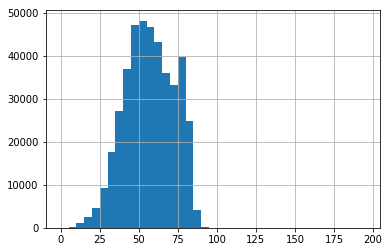

In [9]:
import numpy as np

lens = news.title.str.len()
lens.hist(bins = np.arange(0,200,5))

In [10]:
import re
import string

def clean_text(s):
    s = s.lower()
    for ch in string.punctuation:                                                                                                     
        s = s.replace(ch, " ") 
    s = re.sub("[0-9]+", "||DIG||",s)
    s = re.sub(' +',' ', s)        
    return s

news['text'] = [clean_text(s) for s in news['title']]

In [11]:
news.head()

,title,topic,text
0,"Fed official says weak data caused by weather,...",b,fed official says weak data caused by weather ...
1,Fed's Charles Plosser sees high bar for change...,b,fed s charles plosser sees high bar for change...
2,US open: Stocks fall after Fed official hints ...,b,us open stocks fall after fed official hints a...
3,"Fed risks falling 'behind the curve', Charles ...",b,fed risks falling behind the curve charles plo...
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,b,fed s plosser nasty weather has curbed job growth


Let's use a subset od a dataset for simplicity

In [12]:
df = pd.DataFrame(columns=['title', 'topic', 'text'])

for topic in news.topic.unique():
    temp_df = news[news['topic'] == topic][:5000]
    df = pd.concat([df, temp_df])

In [13]:
df.head()

,title,topic,text
0,"Fed official says weak data caused by weather,...",b,fed official says weak data caused by weather ...
1,Fed's Charles Plosser sees high bar for change...,b,fed s charles plosser sees high bar for change...
2,US open: Stocks fall after Fed official hints ...,b,us open stocks fall after fed official hints a...
3,"Fed risks falling 'behind the curve', Charles ...",b,fed risks falling behind the curve charles plo...
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,b,fed s plosser nasty weather has curbed job growth


In [14]:
df.shape

(20000, 3)

In [15]:
import spacy_sentence_bert

# load one of the models listed at https://github.com/MartinoMensio/spacy-sentence-bert/
nlp = spacy_sentence_bert.load_model('en_stsb_distilbert_base')

In [16]:
df['vector'] = df['title'].apply(lambda x: nlp(x).vector)

In [19]:
tania = [1,2,3]
joel = [0,1,0]
a = [2,3,4]

In [20]:
# tania a joel
[3/3,6/3,7/3]
# tania joel
[1/2, 3/2, 3/2]

[1, 2, 3, 2, 3, 4, 0, 1, 0]

In [17]:
df

,title,topic,text,vector
0,"Fed official says weak data caused by weather,...",b,fed official says weak data caused by weather ...,"[-0.004702461, -0.45349196, 0.02311552, 0.2971..."
1,Fed's Charles Plosser sees high bar for change...,b,fed s charles plosser sees high bar for change...,"[0.11904009, 0.4278946, 1.0144297, -0.60062337..."
2,US open: Stocks fall after Fed official hints ...,b,us open stocks fall after fed official hints a...,"[0.23235139, 0.033100948, 0.47886723, -0.42086..."
3,"Fed risks falling 'behind the curve', Charles ...",b,fed risks falling behind the curve charles plo...,"[-0.46812344, 0.42699397, 0.39376128, -0.32394..."
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,b,fed s plosser nasty weather has curbed job growth,"[-0.3045602, 0.10560442, -0.25209218, -1.32014..."
...,...,...,...,...
46486,"Air pollution killed 7 million people, more th...",m,air pollution killed ||DIG|| million people mo...,"[0.918067, -0.6574964, 0.6018689, -0.72687316,..."
46487,WHO: Pollution kills 7 million people every year,m,who pollution kills ||DIG|| million people eve...,"[0.72617877, -0.20034589, 0.47320244, -0.40602..."
46488,Air pollution killed seven million people in 2...,m,air pollution killed seven million people in |...,"[0.96667284, -0.9736302, 0.48745275, -0.306833..."
46489,Environmental Pollution Seems To Be Posing a B...,m,environmental pollution seems to be posing a b...,"[0.6997536, -0.30608872, -0.39316115, -0.55720..."


Train Classifier

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['vector'].tolist(), df['topic'].tolist(), test_size=0.33, random_state=42)

In [21]:
from sklearn.svm import SVC

clf = SVC(gamma='auto')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [22]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.9328787878787879


In [23]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=9, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8824242424242424


In [42]:
headlines = ["Fed official says weak data caused by weather, should not slow taper", 
             "iPad Air 2 And iPad Mini 3 Release Date",
             "George Zimmerman Has an Armed Life on the Move",
             "Grown-ups: Put down the smartphones at mealtime"
            ]

topics = ['b',  't',  'e', "m"]

In [43]:
for headline, topic in zip(headlines, topics):
    print(headline)
    print(f"True Label: {topic}, Predicted Label: {clf.predict(nlp(headline).vector.reshape(1, -1))[0]} \n")

Fed official says weak data caused by weather, should not slow taper
True Label: b, Predicted Label: b 

iPad Air 2 And iPad Mini 3 Release Date
True Label: t, Predicted Label: t 

George Zimmerman Has an Armed Life on the Move
True Label: e, Predicted Label: e 

Grown-ups: Put down the smartphones at mealtime
True Label: m, Predicted Label: t 

